In [1]:
!nvidia-smi

Sun Oct  1 05:47:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/ultralytics/yolov5.git  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16000, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16000 (delta 20), reused 20 (delta 12), pack-reused 15967
Receiving objects: 100% (16000/16000), 14.59 MiB | 25.55 MiB/s, done.
Resolving deltas: 100% (10986/10986), done.
/content/yolov5


In [3]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.6/615.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [4]:
%cd /content

/content


In [5]:
import gdown

url = "https://drive.google.com/file/d/1uSKxw0yMbSy8TXZix0AM4KOvKRZDQFSi/view?usp=sharing"

file_id = url.split("/")[-2]
print(file_id)
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id)
print("Data downloaded!")

1uSKxw0yMbSy8TXZix0AM4KOvKRZDQFSi


Downloading...
From: https://drive.google.com/uc?/export=download&id=1uSKxw0yMbSy8TXZix0AM4KOvKRZDQFSi
To: /content/Playing-Cards-Object-Detection-Dataset.zip
100%|██████████| 706M/706M [00:08<00:00, 83.3MB/s]

Data downloaded!


In [ ]:
!unzip Playing-Cards-Object-Detection-Dataset.zip
!rm -rf Playing-Cards-Object-Detection-Dataset.zip

In [7]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 52
names: ['10 Clubs', '10 Diamonds', '10 Hearts', '10 Spades', '2 Clubs', '2 Diamonds', '2 Hearts', '2 Spades', '3 Clubs', '3 Diamonds', '3 Hearts', '3 Spades', '4 Clubs', '4 Diamonds', '4 Hearts', '4 Spades', '5 Clubs', '5 Diamonds', '5 Hearts', '5 Spades', '6 Clubs', '6 Diamonds', '6 Hearts', '6 Spades', '7 Clubs', '7 Diamonds', '7 Hearts', '7 Spades', '8 Clubs', '8 Diamonds', '8 Hearts', '8 Spades', '9 Clubs', '9 Diamonds', '9 Hearts', '9 Spades', 'Ace Clubs', 'Ace Diamonds', 'Ace Hearts', 'Ace Spades', 'Jack Clubs', 'Jack Diamonds', 'Jack Hearts', 'Jack Spades', 'King Clubs', 'King Diamonds', 'King Hearts', 'King Spades', 'Queen Clubs', 'Queen Diamonds', 'Queen Hearts', 'Queen Spades']

In [8]:
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
num_classes

'52'

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

In [11]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [12]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [13]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

/content/yolov5
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-225-gbb9706e Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_

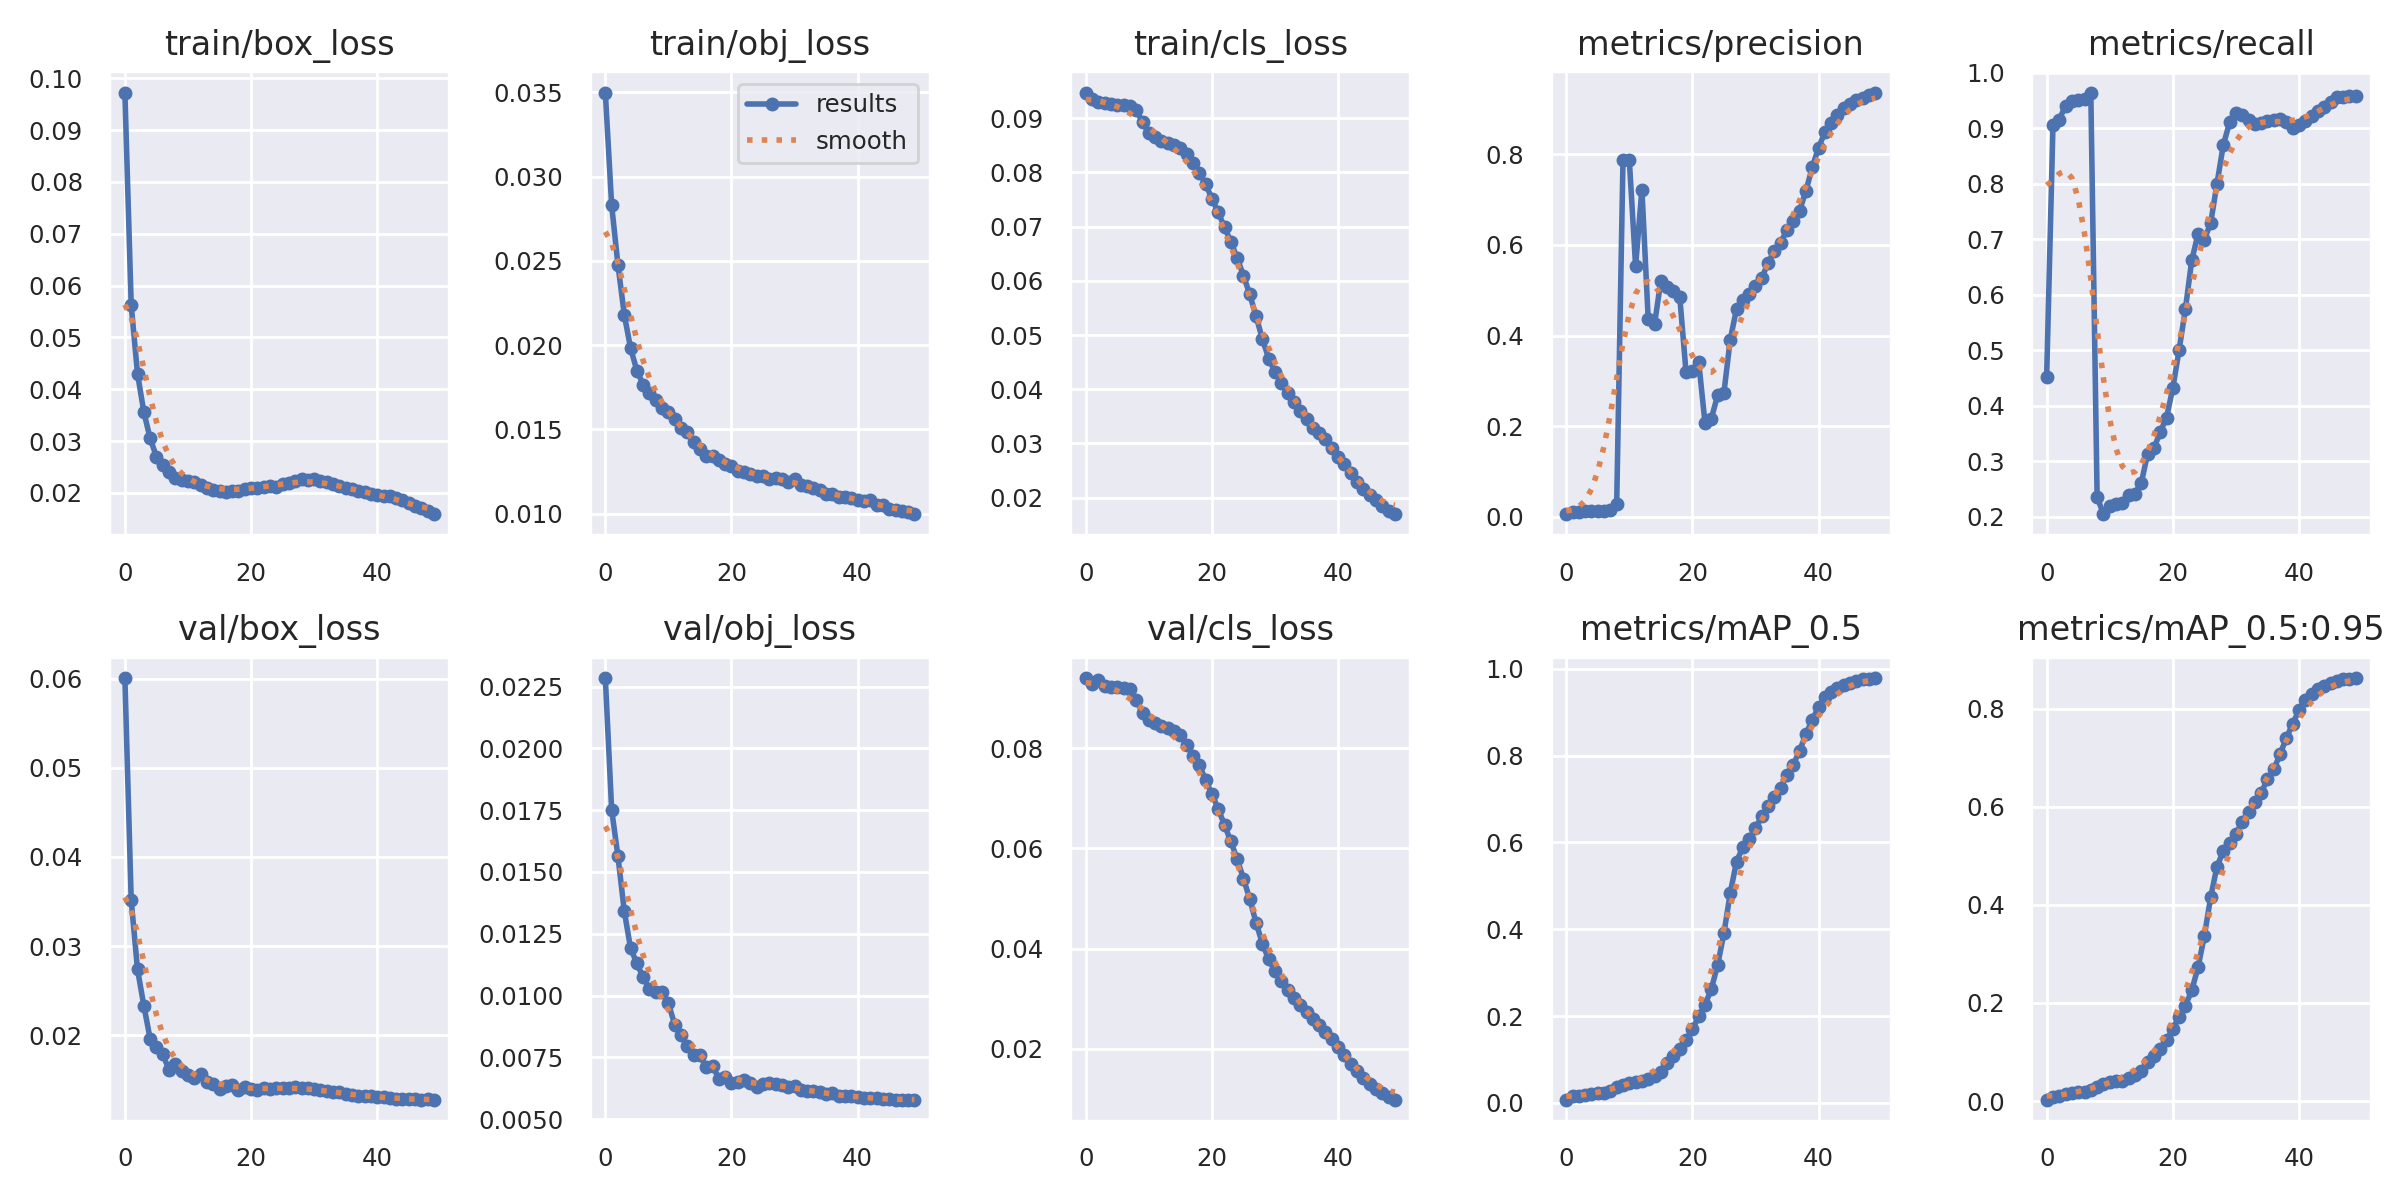

In [15]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)

GROUND TRUTH TRAINING DATA:


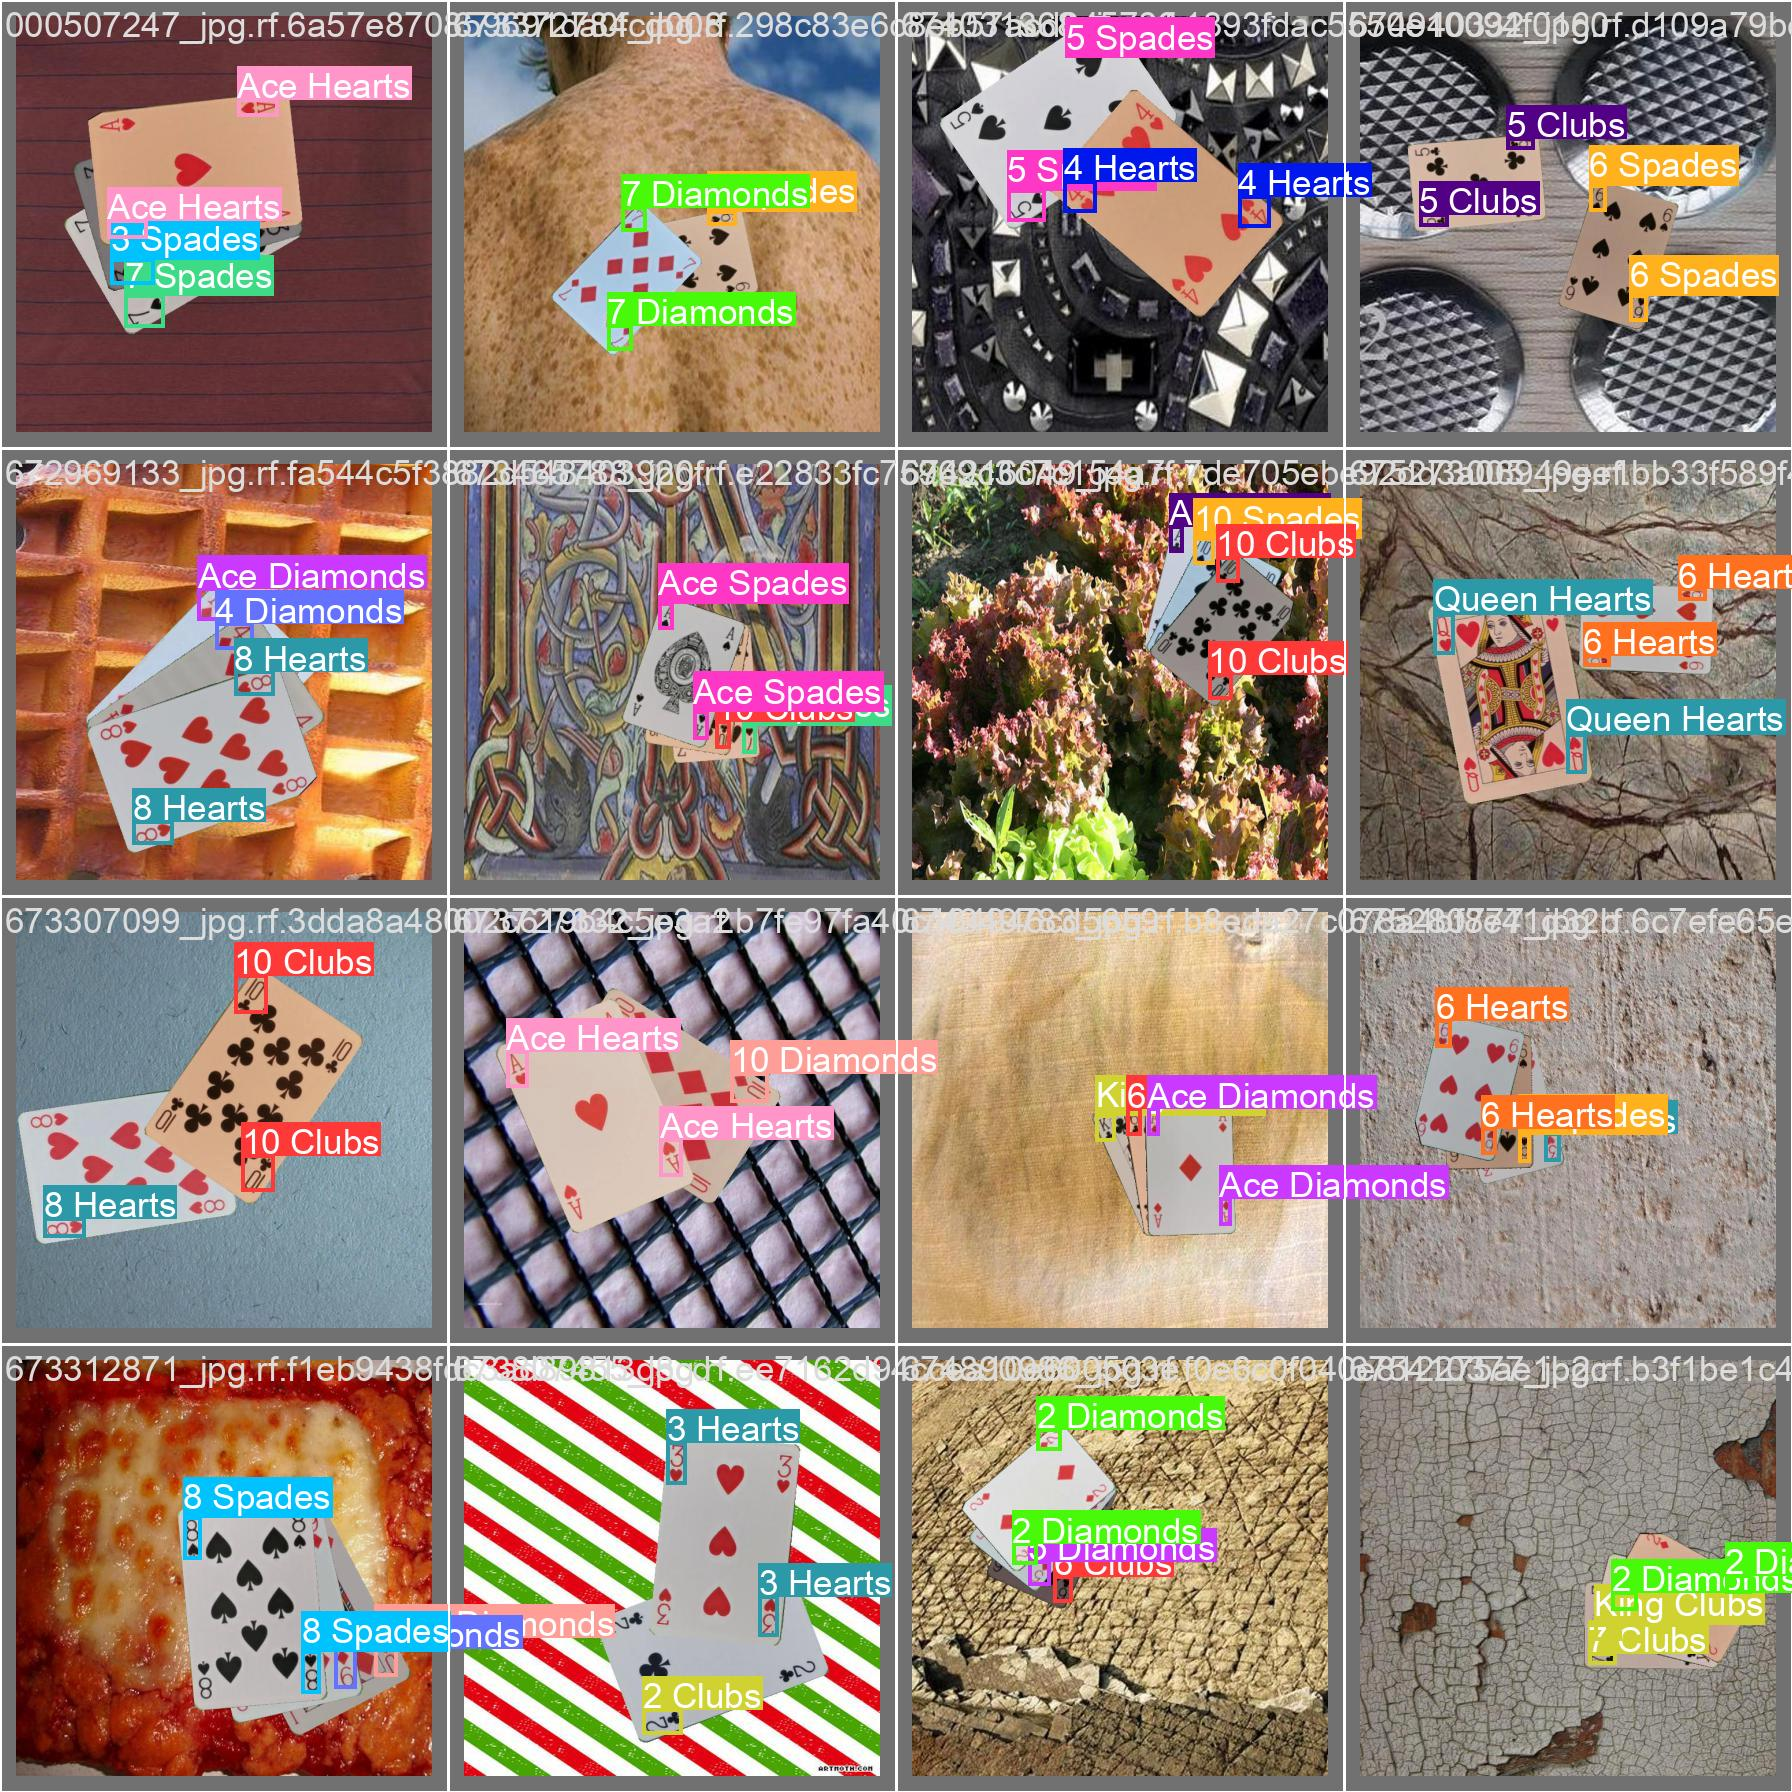

In [16]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


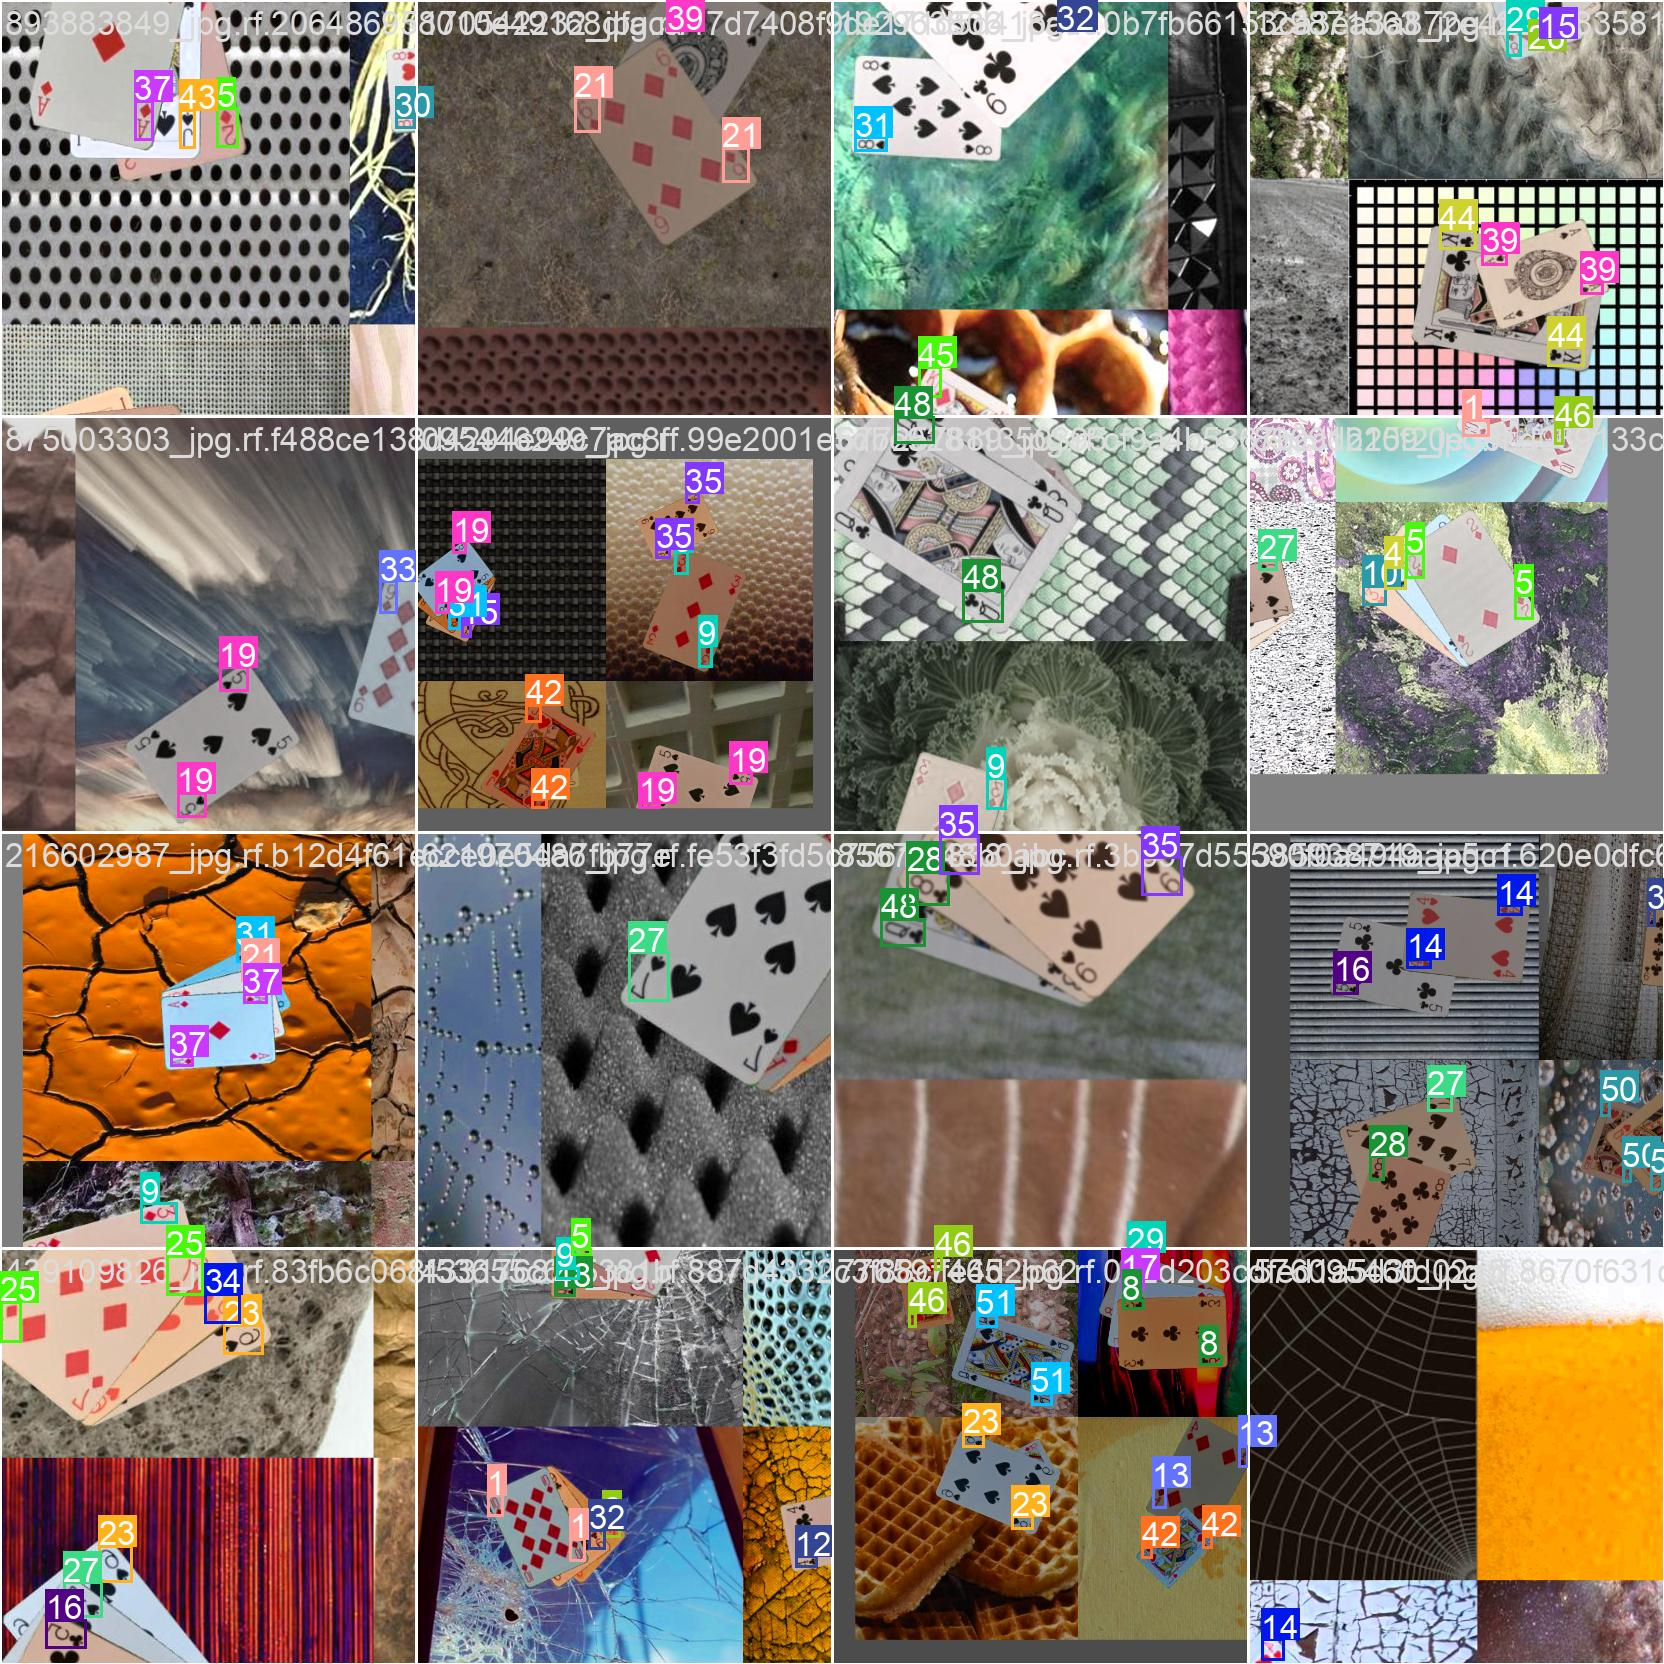

In [17]:
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)